In [ ]:
!pip install Sastrawi

In [ ]:
!pip install transformers

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade pandas

Data shape: (5000, 6)
Loaded 6436 normalization entries
Loaded 1164 stopwords
Melakukan preprocessing...
Jumlah dokumen setelah preprocessing: 4865
Preprocessing selesai dan data disimpan ke 'preprocessed_lda.csv'

Membangun model TF-IDF dan LDA...
Dimensi corpus matrix: (4865, 1161)
Dimensi TF-IDF matrix: (4865, 1161)
Evaluasi model dengan 2 topik...
  - 2 topik: Coherence (C_V) = 0.0196, Perplexity = 1082.88
Evaluasi model dengan 4 topik...
  - 4 topik: Coherence (C_V) = 0.0740, Perplexity = 1224.87
Evaluasi model dengan 6 topik...
  - 6 topik: Coherence (C_V) = 0.1095, Perplexity = 1397.21
Evaluasi model dengan 8 topik...
  - 8 topik: Coherence (C_V) = 0.1163, Perplexity = 1554.16
Evaluasi model dengan 10 topik...
  - 10 topik: Coherence (C_V) = 0.1331, Perplexity = 1687.17
Evaluasi model dengan 12 topik...
  - 12 topik: Coherence (C_V) = 0.1717, Perplexity = 1906.61
Evaluasi model dengan 14 topik...
  - 14 topik: Coherence (C_V) = 0.1705, Perplexity = 1954.61
Evaluasi model dengan 

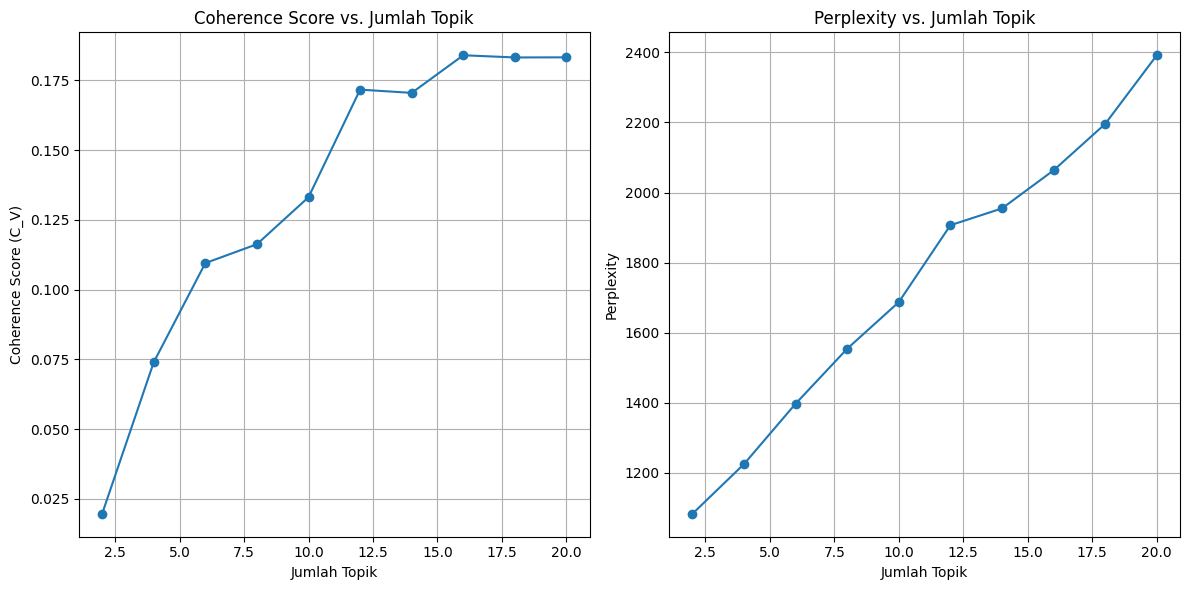


Jumlah topik optimal berdasarkan coherence score C_V: 16

Topik yang ditemukan oleh LDA:
Topik #1: mantap, update, kak, bintang, coba, kasih, kasih bintang, status, admin, suruh
Topik #2: suka, suka galat, suka aplikasi, messages, ribettt, sebal, pergi, galat, aplikasi suka, pindah
Topik #3: jelek, bantu, aplikasi jelek, akses, senang, aplikasi, fungsi, bad, temu, atur
Topik #4: voom, kembali, cerita, buka, fitur, kembali voom, ada, kembali fitur, chat, tidak
Topik #5: aneh, blokir, punya, komunikasi, orang, this, aman, jadi, cant, jadi orang
Topik #6: pesan, kirim, sampah, iklan, keren, aplikasi, terima, aplikasi sampah, kirim pesan, pemberitahuan
Topik #7: masuk, akun, susah, ribet, handphone, aplikasi, pakai, verifikasi, kak, masuk akun
Topik #8: baik, bodoh, sandi, lambat, pakai, koneksi, lupa, timeline, aplikasi, lupa sandi
Topik #9: tinggal, lumayan, selamat, niat, linenya, bangkrut, media, selamat tinggal, semangat, sosial
Topik #10: bagus, oke, good, buruk, aplikasi, virus, ap

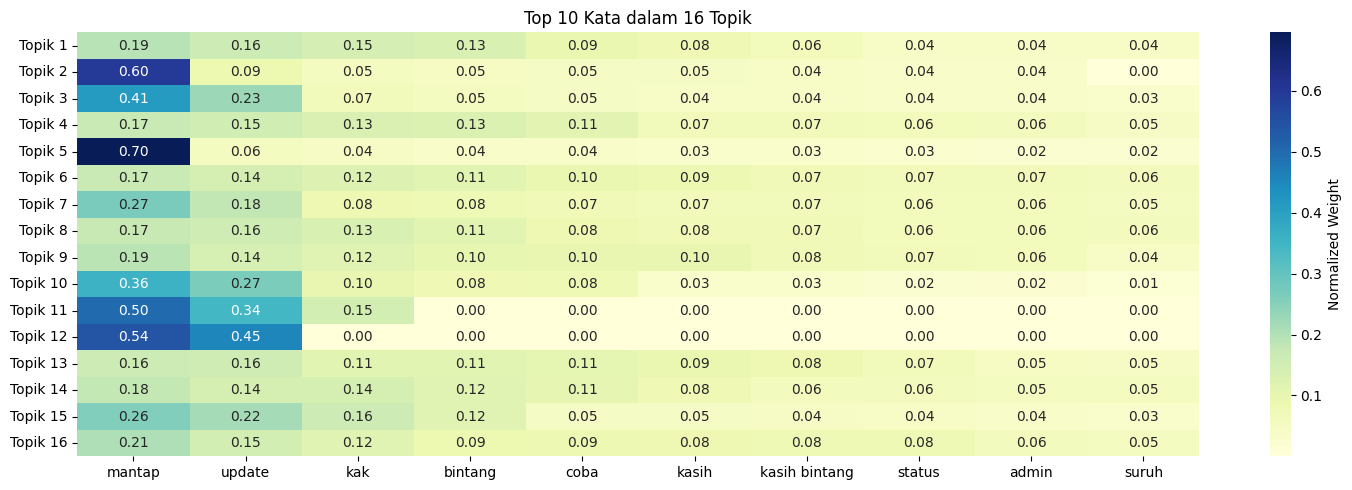


LDA modeling dengan coherence score C_V selesai!


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# Tidak menggunakan gensim
import warnings
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
warnings.filterwarnings('ignore')

# Muat dataset
df = pd.read_csv('line_messenger_reviews.csv')
print(f"Data shape: {df.shape}")

# Pastikan kolom konten tidak null dan berupa string
df = df.dropna(subset=['content'])
df['content'] = df['content'].astype(str)

def clean_text(text):
    """Membersihkan teks dari karakter khusus dan mengubah ke lowercase"""
    # Case folding
    text = text.lower()
    # Hapus karakter khusus, angka, dan emoji
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tokenisasi awal - memecah teks menjadi kata-kata setelah cleaning
def tokenize_text(text):
    """Memecah teks menjadi token kata"""
    return text.split()

# Baca dan gabungkan semua kamus normalisasi
def load_normalization_dictionaries():
    """Memuat dan menggabungkan semua kamus normalisasi"""
    try:
        # Read singkatan-lib.csv
        df_singkatan = pd.read_csv("singkatan-lib.csv")
        df_singkatan = df_singkatan.rename(columns={df_singkatan.columns[0]: "slang",
                                                 df_singkatan.columns[1]: "formal"})

        # Baca colloquial-indonesian-lexicon.csv
        df_colloquial = pd.read_csv("colloquial-indonesian-lexicon.csv", sep=",", usecols=["slang", "formal"])

        # Baca Kamus-alay.csv
        df_alay = pd.read_csv("Kamus-Alay.csv", sep=",", usecols=["kataAlay", "kataBaik"])
        df_alay = df_alay.rename(columns={"kataAlay": "slang", "kataBaik": "formal"})

        # Baca slang.csv
        df_slang = pd.read_csv("slang.csv")
        df_slang = df_slang.rename(columns={df_slang.columns[0]: "slang", df_slang.columns[1]: "formal"})

        # Gabungkan semua kamus
        combined_dict = pd.concat([df_singkatan, df_slang, df_colloquial, df_alay], ignore_index=True)

        # Hapus duplikat dengan prioritas pada entri pertama
        combined_dict = combined_dict.drop_duplicates(subset=['slang'], keep='first')

        # Konversi ke dictionary (hapus entri kosong)
        normalization_dict = combined_dict.dropna().set_index("slang")["formal"].to_dict()

        print(f"Loaded {len(normalization_dict)} normalization entries")
        return normalization_dict

    except Exception as e:
        print(f"Error loading dictionaries: {e}")
        return {}

# Muat kamus normalisasi
normalization_dict = load_normalization_dictionaries()

# Normalisasi kata gabungan dengan regex
def normalize_merged_words(tokens):
    """Menormalkan pola kata gabungan yang umum"""
    normalized_tokens = []

    for token in tokens:
        # Tangani pola "ga" + konsonan (contoh: gabisa -> tidak bisa)
        if re.match(r'\bga([bpmdtcjszkgfhv])', token):
            token = re.sub(r'\bga([bpmdtcjszkgfhv]\w*)', r'tidak \1', token)
            # Pisahkan hasil substitusi jika menghasilkan 2 kata
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue

        # Tangani pola "ga" + vokal (contoh: gausah -> tidak usah)
        elif re.match(r'\bgau([a-z])', token):
            token = re.sub(r'\bgau([a-z]\w*)', r'tidak u\1', token)
            # Pisahkan hasil substitusi jika menghasilkan 2 kata
            if ' ' in token:
                normalized_tokens.extend(token.split())
                continue

        normalized_tokens.append(token)

    return normalized_tokens

# Normalisasi token dengan kamus
def normalize_tokens(tokens):
    """Menormalkan token menggunakan kamus normalisasi"""
    return [normalization_dict.get(token, token) for token in tokens]

# Muat stopwords
def load_stopwords():
    """Memuat dan menggabungkan daftar stopwords dari berbagai sumber"""
    def load_stopwords_file(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                return f.read().split()
        except Exception as e:
            print(f"Warning: Could not load {file_path}: {e}")
            return []

    # Path file stopword
    stoplist_path = "stoplist.txt"
    indonesian_path = "indonesian.txt"
    stopwordsid_path = "stopwords-id.txt"
    id_stopwords_path = "id.stopwords.02.01.2016.txt"
    kamus_path = "kamus.txt"

    # Muat stopwords dari files
    stopwords_combined = []
    for path in [stoplist_path, indonesian_path, stopwordsid_path, id_stopwords_path, kamus_path]:
        stopwords_combined.extend(load_stopwords_file(path))

    # Dapatkan stopwords dari Sastrawi
    stopword_factory = StopWordRemoverFactory()
    sastrawi_stopwords = stopword_factory.get_stop_words()

    # Gabungkan dan hapus duplikat
    stopwords_combined.extend(sastrawi_stopwords)

    # Tambahkan kata kustom
    custom_stopwords = ['line', 'nya', 'sih', 'yg', 'dah', 'ga', 'gak', 'aja', 'saja', 'juga', 'untuk']
    stopwords_combined.extend(custom_stopwords)

    final_stopwords = list(set(stopwords_combined))

    print(f"Loaded {len(final_stopwords)} stopwords")
    return final_stopwords

# Muat stopwords
final_stopwords = load_stopwords()

# Hapus stopwords
def remove_stopwords(tokens):
    """Menghapus stopwords dari daftar token"""
    return [token for token in tokens if token not in final_stopwords and len(token) > 1]

# Inisialisasi stemmer
stemmer = StemmerFactory().create_stemmer()

# Stem token
def stem_tokens(tokens):
    """Melakukan stemming pada daftar token"""
    return [stemmer.stem(token) for token in tokens]

# Pipeline preprocessing lengkap
def preprocess_text(text):
    """Pipeline preprocessing lengkap"""
    if pd.isna(text) or text == "":
        return []

    # 1. Cleaning
    cleaned = clean_text(text)

    # 2. Tokenisasi awal
    tokens = tokenize_text(cleaned)

    # 3. Normalisasi kata gabungan
    tokens = normalize_merged_words(tokens)

    # 4. Normalisasi dengan kamus
    tokens = normalize_tokens(tokens)

    # 5. Hapus stopwords
    tokens = remove_stopwords(tokens)

    # 6. Stemming
    tokens = stem_tokens(tokens)

    # 7. Filter token terlalu pendek
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

# Terapkan preprocessing
print("Melakukan preprocessing...")
df['tokens'] = df['content'].apply(preprocess_text)

# Hapus dokumen kosong setelah preprocessing
df = df[df['tokens'].apply(len) > 0]
print(f"Jumlah dokumen setelah preprocessing: {df.shape[0]}")

# Simpan teks yang sudah di-preprocess sebagai string untuk TF-IDF
df['preprocessed_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Simpan data untuk LDA
lda_df = df[['preprocessed_text', 'tokens']]
lda_df.to_csv('preprocessed_lda.csv', index=False)

print("Preprocessing selesai dan data disimpan ke 'preprocessed_lda.csv'")

# Untuk melanjutkan ke TF-IDF dan LDA:
print("\nMembangun model TF-IDF dan LDA...")

# ======= PERUBAHAN 1: Gunakan CountVectorizer untuk corpus asli =======
# Count vectorizer untuk corpus asli (untuk perhitungan coherence)
count_vectorizer = CountVectorizer(
    min_df=5,              # Abaikan kata yang muncul di kurang dari 5 dokumen
    max_df=0.5,            # Abaikan kata yang muncul di lebih dari 50% dokumen
    ngram_range=(1, 2)     # Gunakan unigram dan bigram
)

# Fit dan transform data untuk membuat corpus term-document frequency
count_matrix = count_vectorizer.fit_transform(df['preprocessed_text'])
corpus = count_matrix.toarray()
vocabulary = count_vectorizer.get_feature_names_out()
print(f"Dimensi corpus matrix: {corpus.shape}")

# Buat vectorizer TF-IDF dengan parameter yang optimal
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,              # Abaikan kata yang muncul di kurang dari 5 dokumen
    max_df=0.5,            # Abaikan kata yang muncul di lebih dari 50% dokumen
    use_idf=True,
    ngram_range=(1, 2),    # Gunakan unigram dan bigram
    vocabulary=count_vectorizer.vocabulary_  # Gunakan vocabulary yang sama dari corpus
)

# Fit dan transform data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['preprocessed_text'])
print(f"Dimensi TF-IDF matrix: {tfidf_matrix.shape}")

# ======= PERUBAHAN 2: Implementasi C_V Coherence Score =======
def calculate_cv_coherence(topics, tokens_list, corpus, vocabulary):
    """
    Menghitung coherence score berdasarkan metrik C_V tanpa menggunakan Gensim

    C_V coherence mengukur similaritas antara kata-kata dalam topik
    menggunakan distribusi kemunculan kata dalam dokumen
    """
    vocab_index = {word: idx for idx, word in enumerate(vocabulary)}
    topic_count = len(topics)
    total_coherence = 0

    # Untuk efisiensi, hitung word-document frequency terlebih dahulu
    word_doc_counts = defaultdict(set)
    for doc_idx, doc_tokens in enumerate(tokens_list):
        for token in set(doc_tokens):  # Gunakan set() untuk unique tokens per dokumen
            if token in vocab_index:
                word_doc_counts[token].add(doc_idx)

    # Hitung jumlah total dokumen
    num_docs = len(tokens_list)

    # Iterasi untuk setiap topik
    for topic_words in topics:
        # Filter kata-kata yang tidak ada dalam vocabulary
        valid_words = [w for w in topic_words if w in vocab_index]
        if len(valid_words) < 2:  # Perlu minimal 2 kata untuk menghitung koherensi
            continue

        # Hitung segala pasangan kata
        topic_coherence = 0
        pair_count = 0

        # Iterasi untuk setiap pasangan kata
        for i in range(len(valid_words)):
            for j in range(i+1, len(valid_words)):
                word_i = valid_words[i]
                word_j = valid_words[j]

                # Dokumen yang mengandung masing-masing kata
                docs_i = word_doc_counts.get(word_i, set())
                docs_j = word_doc_counts.get(word_j, set())

                # Dokumen yang mengandung kedua kata
                docs_both = docs_i.intersection(docs_j)

                # Jumlah dokumen
                n_i = len(docs_i)
                n_j = len(docs_j)
                n_both = len(docs_both)

                # Hitung NPMI (Normalized Pointwise Mutual Information)
                # Smoothing untuk menghindari log(0)
                epsilon = 0.000001

                # Probabilitas
                p_i = (n_i + epsilon) / num_docs
                p_j = (n_j + epsilon) / num_docs
                p_both = (n_both + epsilon) / num_docs

                # PMI = log(P(i,j) / (P(i) * P(j)))
                pmi = np.log10(p_both / (p_i * p_j))

                # NPMI = PMI / -log(P(i,j))
                if p_both > epsilon:  # Hindari log(epsilon)
                    npmi = pmi / (-np.log10(p_both))
                    topic_coherence += npmi
                    pair_count += 1

        # Rataan coherence untuk topik ini
        if pair_count > 0:
            avg_topic_coherence = topic_coherence / pair_count
            total_coherence += avg_topic_coherence

    # Rataan coherence dari semua topik
    if topic_count > 0:
        return total_coherence / topic_count
    else:
        return 0

# Fungsi untuk mengevaluasi model LDA dengan berbagai jumlah topik
def evaluate_lda_models(tfidf_matrix, tokens_list, corpus, vocabulary, topic_nums=range(2, 21, 2)):
    """Mengevaluasi model LDA dengan berbagai jumlah topik dan menghitung coherence score C_V"""
    coherence_scores = []
    perplexity_scores = []

    for num_topics in topic_nums:
        print(f"Evaluasi model dengan {num_topics} topik...")

        # Inisialisasi dan latih model LDA
        lda_model = LatentDirichletAllocation(
            n_components=num_topics,
            learning_method='online',
            random_state=42,
            max_iter=25,
            learning_offset=50.0,
            doc_topic_prior=0.1,  # Alpha parameter
            topic_word_prior=0.01  # Beta parameter
        )

        lda_model.fit(tfidf_matrix)

        # Hitung perplexity
        perplexity = lda_model.perplexity(tfidf_matrix)
        perplexity_scores.append(perplexity)

        # Ekstrak topik
        topics = []
        feature_names = tfidf_vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(lda_model.components_):
            top_words_idx = topic.argsort()[:-11:-1]  # Top 10 kata
            top_words = [feature_names[i] for i in top_words_idx]
            topics.append(top_words)

        # Hitung coherence score C_V
        coherence = calculate_cv_coherence(topics, tokens_list, corpus, vocabulary)
        coherence_scores.append(coherence)
        print(f"  - {num_topics} topik: Coherence (C_V) = {coherence:.4f}, Perplexity = {perplexity:.2f}")

    return topic_nums, coherence_scores, perplexity_scores

# Evaluasi berbagai model LDA dengan coherence score C_V
topic_nums, coherence_scores, perplexity_scores = evaluate_lda_models(
    tfidf_matrix,
    df['tokens'].tolist(),
    corpus,
    vocabulary,
    topic_nums=range(2, 21, 2)
)

# Plot hasil evaluasi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(topic_nums, coherence_scores, marker='o')
plt.xlabel('Jumlah Topik')
plt.ylabel('Coherence Score (C_V)')
plt.title('Coherence Score vs. Jumlah Topik')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(topic_nums, perplexity_scores, marker='o')
plt.xlabel('Jumlah Topik')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Jumlah Topik')
plt.grid(True)

plt.tight_layout()
plt.savefig('lda_evaluation.png')
plt.show()

# Temukan jumlah topik optimal (dengan coherence score tertinggi)
optimal_num_topics = topic_nums[coherence_scores.index(max(coherence_scores))]
print(f"\nJumlah topik optimal berdasarkan coherence score C_V: {optimal_num_topics}")

# Latih model LDA final dengan jumlah topik optimal
final_lda_model = LatentDirichletAllocation(
    n_components=optimal_num_topics,
    learning_method='online',
    random_state=42,
    max_iter=40,  # Lebih banyak iterasi untuk model final
    learning_offset=50.0,
    doc_topic_prior=0.1,  # Alpha parameter
    topic_word_prior=0.01  # Beta parameter
)

final_lda_model.fit(tfidf_matrix)

# Tampilkan topik
print("\nTopik yang ditemukan oleh LDA:")
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(final_lda_model.components_):
    top_words_idx = topic.argsort()[:-11:-1]  # Top 10 kata
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topik #{topic_idx+1}: {', '.join(top_words)}")

# Visualisasi topik menggunakan heatmap
def plot_top_words(lda, feature_names, n_top_words, title):
    """Visualisasi topik LDA menggunakan heatmap"""
    fig, axes = plt.subplots(1, 1, figsize=(15, n_top_words * 0.5),
                             sharex=True)

    # Siapkan data untuk heatmap
    top_words_data = []
    topic_labels = []
    word_labels = []

    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_weights = [topic[i] for i in top_words_idx]

        # Normalisasi bobot untuk setiap topik
        top_weights = np.array(top_weights) / sum(top_weights)

        topic_label = f"Topik {topic_idx+1}"
        topic_labels.append(topic_label)

        if not word_labels:  # Set label kata hanya sekali
            word_labels = top_words

        top_words_data.append(top_weights)

    # Buat heatmap
    top_words_df = pd.DataFrame(top_words_data, index=topic_labels, columns=word_labels)
    sns.heatmap(top_words_df, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Normalized Weight'})

    plt.title(title)
    plt.tight_layout()
    plt.savefig('lda_topics_heatmap.png')
    plt.show()

# Visualisasi topik
plot_top_words(final_lda_model, feature_names, 10, f'Top 10 Kata dalam {optimal_num_topics} Topik')

print("\nLDA modeling dengan coherence score C_V selesai!")